### Imports 

In [9]:
%matplotlib inline
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools

In [10]:
print(f'Using TensorFlow version: {tf.__version__}')

Using TensorFlow version: 2.3.0


#### Seed for Reproducability

In [11]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load & Prep Data

In [12]:
train_path  = './DATA/SIGN_LANGUAGE/train'
validation_path  = './DATA/SIGN_LANGUAGE/valid'
test_path  = './DATA/SIGN_LANGUAGE/test'

#### Explore Data

In [13]:
img = mpimg.imread(f'{train_path}/0/IMG_1118.JPG')

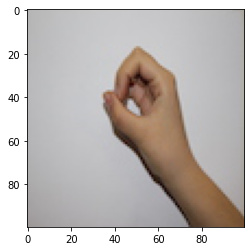

In [14]:
plt.imshow(img)

In [15]:
img.shape

(100, 100, 3)

<p>ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches).<br>
    <b>Note:</b> In this example, we won't be doing any image augmentation.</p>

In [16]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224, 224), 
                                                         batch_size=10)

Found 1712 images belonging to 10 classes.


In [17]:
train_batches.next()[0][0].shape

(224, 224, 3)

#### Visualize Random Sample of Images from Train Batch

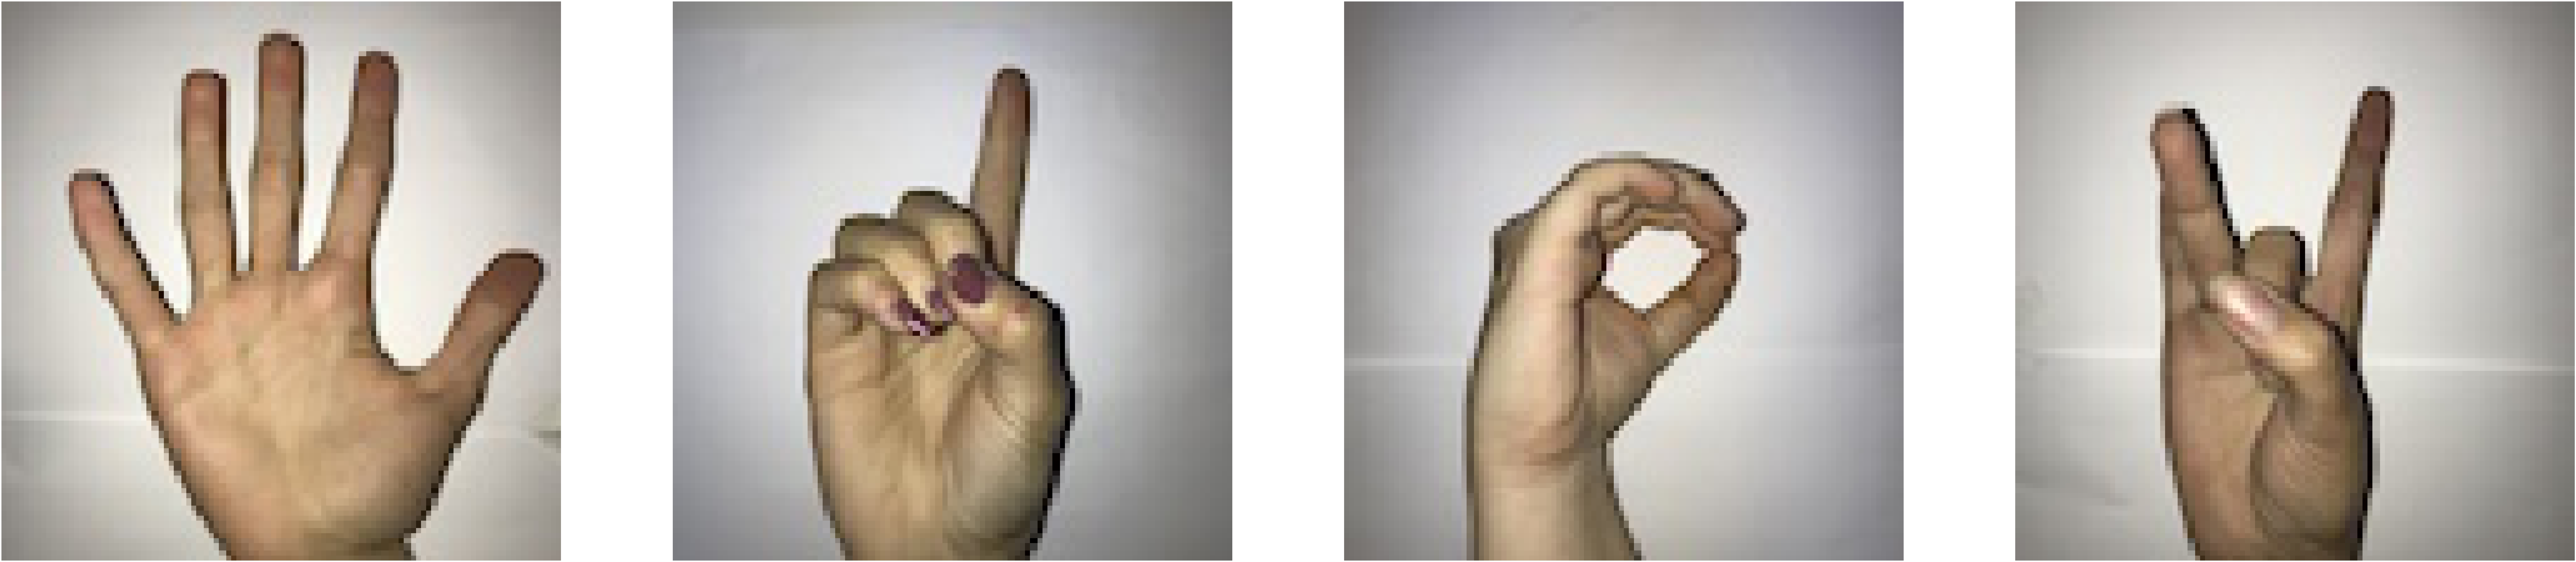

In [18]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(224, 224))
for row in rows:
    row.imshow(train_batches.next()[0][0].astype('int'))
    row.axis('off')
plt.show()

In [19]:
validation_batches = ImageDataGenerator().flow_from_directory(validation_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

Found 300 images belonging to 10 classes.


In [20]:
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 50 images belonging to 10 classes.


### Load Base Model
#### VGG16 CNN Model pre-trained on ImageNet dataset

In [21]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Freeze the Classification Layers in Base Model

In [22]:
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Define New Model

In [23]:
# get last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Compile the New Model

In [24]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the New Model

In [25]:
checkpointer = ModelCheckpoint(filepath='sign-language.model.hdf5', save_best_only=True)

<p><b>Note: </b>Since we have 1,712 images in the training dataset (across all classes) 
and a batch size of 10 assigned, the steps_per_epoch would be about 18, or 1712/10.</p>
<p> We take the ceiling because we do not drop the remainder of the batch.</p>

In [26]:
history = new_model.fit(train_batches, 
                        steps_per_epoch=18, 
                        validation_data=validation_batches, 
                        validation_steps=3, 
                        epochs=20, 
                        verbose=1, 
                        callbacks=[checkpointer])

Epoch 1/20
18/18 [==============================] - 98s 5s/step - loss: 3.1183 - accuracy: 0.2722 - val_loss: 2.0433 - val_accuracy: 0.2556
Epoch 2/20
18/18 [==============================] - 96s 5s/step - loss: 1.5267 - accuracy: 0.5111 - val_loss: 0.9648 - val_accuracy: 0.7000
Epoch 3/20
18/18 [==============================] - 96s 5s/step - loss: 0.7878 - accuracy: 0.7056 - val_loss: 0.6988 - val_accuracy: 0.7889
Epoch 4/20
18/18 [==============================] - 93s 5s/step - loss: 0.5847 - accuracy: 0.7965 - val_loss: 0.4479 - val_accuracy: 0.7778
Epoch 5/20
18/18 [==============================] - 95s 5s/step - loss: 0.4502 - accuracy: 0.8611 - val_loss: 0.3282 - val_accuracy: 0.9556
Epoch 6/20
18/18 [==============================] - 95s 5s/step - loss: 0.2093 - accuracy: 0.9333 - val_loss: 0.1285 - val_accuracy: 0.9667
Epoch 7/20
18/18 [==============================] - 97s 5s/step - loss: 0.1235 - accuracy: 0.9556 - val_loss: 0.1036 - val_accuracy: 0.9556
Epoch 8/20
18/18 [==

### Visualize Training

In [27]:
def plot_training_history(history):          
    hist = pd.DataFrame(history.history)          
    hist['epoch'] = history.epoch          
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Accuracy')          
    plt.plot(hist['epoch'], hist['accuracy'] * 100, label='Train Accuracy')          
    plt.plot(hist['epoch'], hist['val_accuracy'] * 100, label='Validation Accuracy')
    plt.ylim([0, 100])          
    plt.legend()  
    
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Loss')          
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')          
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.ylim([0,2])
    plt.legend()          
    plt.show()

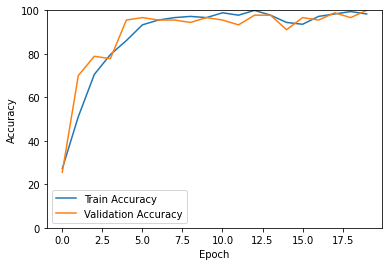

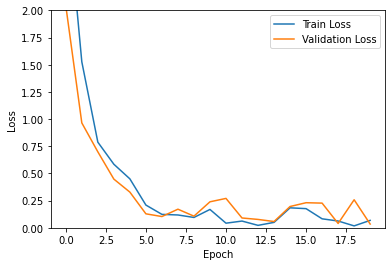

In [28]:
plot_training_history(history)

### Evaluate Model

In [29]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from tensorflow.keras import utils
from tqdm import tqdm
import numpy as np

In [30]:
test_data = load_files('DATA/SIGN_LANGUAGE/test')

In [31]:
test_files = np.array(test_data['filenames'])
test_targets = utils.to_categorical(np.array(test_data['target']))

In [32]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 50/50 [00:00<00:00, 649.56it/s]


In [33]:
%%time 

model = load_model('sign-language.model.hdf5')

CPU times: user 309 ms, sys: 97.8 ms, total: 407 ms
Wall time: 470 ms


In [34]:
result = model.evaluate(test_tensors, test_targets, verbose=1)
print(f'Test Accuracy: {result[1]}')

2/2 [==============================] - 6s 3s/step - loss: 0.2589 - accuracy: 0.9000
Test Accuracy: 0.8999999761581421


#### Create Confusion Matrix 

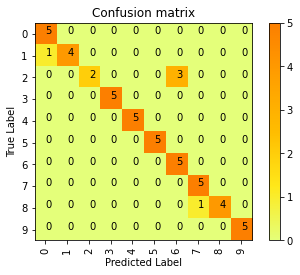

In [35]:
cm_labels = ['0','1','2','3','4','5','6','7','8','9']
cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Wistia)
plt.colorbar()
indices = np.arange(len(cm_labels))
for i in indices:
    for j in indices:
        plt.text(j, i, cm[i, j])
plt.xticks(indices, cm_labels, rotation=90)
plt.xlabel('Predicted Label')
plt.yticks(indices, cm_labels)
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()